# Importing Libraries

In [1]:
import pandas as pd
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Data Loading and Pre-processing

In [2]:
df = pd.read_csv('/kaggle/input/faces-age-detection-dataset/faces/train.csv')
df

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
...,...,...
19901,2482.jpg,MIDDLE
19902,20085.jpg,YOUNG
19903,19663.jpg,MIDDLE
19904,10132.jpg,MIDDLE


In [3]:
images_dir = '/kaggle/input/faces-age-detection-dataset/faces/Train/'

In [4]:
len(os.listdir('/kaggle/input/faces-age-detection-dataset/faces/Train/'))

19906

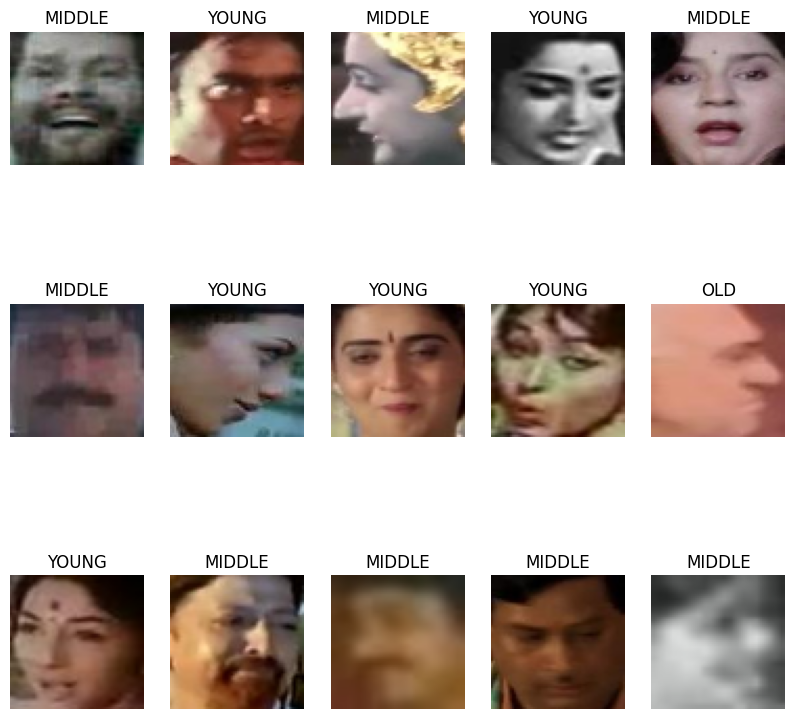

In [5]:
plt.figure(figsize=(10,10))

for i,row in df.iterrows():
    
    if i<15:
        ax = plt.subplot(3, 5, i+1)

        img = plt.imread(images_dir + row['ID'])

        plt.imshow(cv2.resize(img, (64,64)), cmap='gray')

        plt.title(row['Class'])

        plt.axis("off")
    

In [6]:
df['path'] = images_dir + df['ID']

In [83]:
df['Class'].value_counts(normalize=True)

Class
MIDDLE    0.542751
YOUNG     0.336883
OLD       0.120366
Name: proportion, dtype: float64

In [7]:
df['path'][0]

'/kaggle/input/faces-age-detection-dataset/faces/Train/377.jpg'

In [8]:
from sklearn.model_selection import train_test_split

def dataset_splitter(dataset, train_size = 0.8, shuffle = True, random_state = 0):
    train_df, val_df = train_test_split(dataset, train_size = train_size, shuffle = shuffle, random_state = random_state)

    train_df = train_df.reset_index(drop = True)
    val_df = val_df.reset_index(drop = True)
    
    return train_df, val_df

In [9]:
train_df, val_df= dataset_splitter(df)

print(f'\nTraining Dataframe of shape {train_df.shape}: \n{train_df.head()}')
print(f'\nValidation Dataframe of shape {val_df.shape}: \n{val_df.head()}')


Training Dataframe of shape (15924, 3): 
          ID   Class                                               path
0  24370.jpg  MIDDLE  /kaggle/input/faces-age-detection-dataset/face...
1  18939.jpg  MIDDLE  /kaggle/input/faces-age-detection-dataset/face...
2  10376.jpg  MIDDLE  /kaggle/input/faces-age-detection-dataset/face...
3  16100.jpg     OLD  /kaggle/input/faces-age-detection-dataset/face...
4   8583.jpg   YOUNG  /kaggle/input/faces-age-detection-dataset/face...

Validation Dataframe of shape (3982, 3): 
          ID   Class                                               path
0  11790.jpg  MIDDLE  /kaggle/input/faces-age-detection-dataset/face...
1  16320.jpg  MIDDLE  /kaggle/input/faces-age-detection-dataset/face...
2  17307.jpg  MIDDLE  /kaggle/input/faces-age-detection-dataset/face...
3  26285.jpg  MIDDLE  /kaggle/input/faces-age-detection-dataset/face...
4  18500.jpg  MIDDLE  /kaggle/input/faces-age-detection-dataset/face...


In [86]:
train_df['Class'].value_counts(normalize=True)

Class
MIDDLE    0.543896
YOUNG     0.335782
OLD       0.120322
Name: proportion, dtype: float64

In [87]:
val_df['Class'].value_counts(normalize=True)

Class
MIDDLE    0.538172
YOUNG     0.341286
OLD       0.120542
Name: proportion, dtype: float64

- There is class imalance in our dataset. So setting class weights for effective training. To assign higher importance to minority classes. This way, the model penalizes misclassifications for the "OLD" category more than others.

In [88]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Replace 'label' with the name of your label column in the DataFrame
labels = train_df['Class'].values

# Find the unique classes in the labels
classes = np.unique(labels)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)

# Create a dictionary of class weights
class_weight_dict = dict(zip(classes, class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {'MIDDLE': 0.6128622560905207, 'OLD': 2.77035490605428, 'YOUNG': 0.9927061903871329}


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
IMG_SIZE = (64, 64)

train_generator = ImageDataGenerator(1./255)

val_generator = ImageDataGenerator(1./255)

train_images = train_generator.flow_from_dataframe(train_df, x_col = 'path', y_col = 'Class', 
                                                   class_mode = 'categorical', batch_size = BATCH_SIZE,
                                                   target_size = IMG_SIZE, shuffle = True, seed = 0)

val_images = val_generator.flow_from_dataframe(val_df, x_col = 'path', y_col = 'Class',class_mode = 'categorical', 
                                               batch_size = BATCH_SIZE, target_size = IMG_SIZE)

Found 15924 validated image filenames belonging to 3 classes.
Found 3982 validated image filenames belonging to 3 classes.


In [12]:
train_images.class_indices

{'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}

In [13]:
class_names = list(train_images.class_indices.keys())
class_names

['MIDDLE', 'OLD', 'YOUNG']

In [ ]:
for image, label in train_images:
    plt.imshow(image[12].astype("uint8"))
    plt.title(class_names[np.argmax(label[12])])
    print(image.shape)
    break

In [14]:
import tensorflow as tf
from keras import layers, models

resize_and_rescale = tf.keras.Sequential([

  layers.Resizing(64, 64),

  layers.Rescaling(1./255),

])

In [15]:
input_shape = (BATCH_SIZE, 64, 64, 3)  # Grayscale images with size 48x48 and 1 channel

n_classes = len(class_names)

n_classes

3

In [93]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPU: {gpus}")
else:
    print("No GPU available.")

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [94]:
model = models.Sequential([
    layers.Input(input_shape[1:]),
    resize_and_rescale,
    # First Convolutional Block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Third Convolutional Block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output Layer for Classification
    layers.Dense(n_classes, activation='softmax'),
])

# model.build(input_shape=input_shape)

In [95]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 128)            │           51

 Total params: 1,346,723 (5.14 MB)

 Trainable params: 1,345,443 (5.13 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [96]:
model.compile(

    optimizer='adam',

    loss=tf.keras.losses.CategoricalCrossentropy(),

    metrics=['accuracy']

)

In [97]:
# Code for early stopping if model not improves after some consecutive epochs to avoid overfitting.
early_stopping = tf.keras.callbacks.EarlyStopping(
    
    monitor='val_loss', # Monitor validation loss
    
    patience=10,           # Stop if no improvement for 3 consecutive epochs
    
    min_delta=0.001,      # Consider significant improvement if change > 0.001
    
    restore_best_weights=True, # Restore best weights at the end
    
    verbose=1,             # Print when early stopping is triggered
    
)

In [98]:
cnn_model = model.fit(

    train_images,

    batch_size=BATCH_SIZE,

    validation_data=val_images,

    verbose=1,

    epochs=50,

    callbacks=[early_stopping],
    
    class_weight=class_weight_dict

)

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 78s 244ms/step - accuracy: 0.4558 - loss: 1.3645 - val_accuracy: 0.2413 - val_loss: 1.9182
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.6293 - loss: 0.8616 - val_accuracy: 0.6047 - val_loss: 0.8348
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.6719 - loss: 0.7544 - val_accuracy: 0.6705 - val_loss: 0.7454
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.7108 - loss: 0.6840 - val_accuracy: 0.7190 - val_loss: 0.6945
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.7260 - loss: 0.6455 - val_accuracy: 0.7223 - val_loss: 0.6594
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.7375 - loss: 0.6202 - val_accuracy: 0.7622 - val_loss: 0.5660
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.7620 - loss: 0.5726 - val_accuracy: 0.7514 - val_loss: 0.5866
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.7756 - loss: 0.5530 -

In [99]:
result = model.evaluate(val_images, verbose=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.7921 - loss: 0.5041


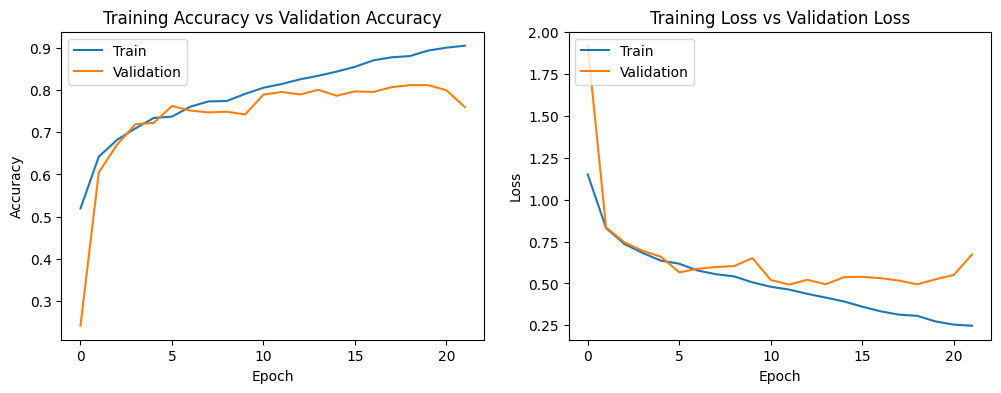

In [100]:
fig , ax = plt.subplots(1,2)
# train_acc = cnn_model.history['accuracy']
# train_loss = cnn_model.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(cnn_model.history['accuracy'])
ax[0].plot(cnn_model.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(cnn_model.history['loss'])
ax[1].plot(cnn_model.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [101]:
!pip install mtcnn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [102]:
from mtcnn import MTCNN
import cv2




def predict_age(image):
    
    detector = MTCNN()

        
    # Detect faces
    faces = detector.detect_faces(image)
    print(len(faces))
    # Extract faces
    for face in faces:
        x, y, width, height = face['box']
        face_image = image[y:y+height, x:x+width]
        plt.imshow(face_image)
        face_image = cv2.resize(face_image, (64,64))

        img_batch = np.expand_dims(face_image, axis=0)
        prediction = model.predict(img_batch)
        age_class = class_names[np.argmax(prediction)]
        
        return prediction, age_class

In [103]:
class_names

['MIDDLE', 'OLD', 'YOUNG']

1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[1.1271146e-01 2.6666155e-04 8.8702196e-01]]
YOUNG


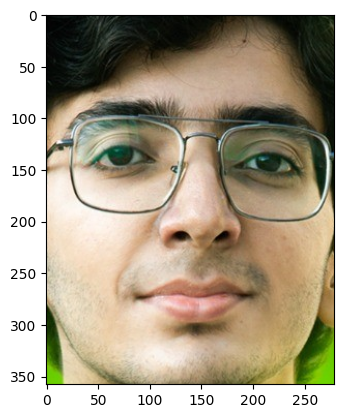

In [115]:
# Load image
image = plt.imread("/kaggle/input/testing/1727172967258.jpeg")

pred, age = predict_age(image)

print(pred)
print(age)

In [116]:
model.save('models/my_model.h5')